In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import random, randrange
from numba import jit
from copy import deepcopy

""" Solve the traveling salesman problem using a simulated annealing global minimization routine"""

@jit(nopython = True)
def distance(r, N):
    """ 
    simple function to calculate distance between two points
    r is array of N [x,y] coordinates
    This function is used internally on MC step, so it is necessary to jit.
    """
    
    D = 0
    for ii in range(N):
        dr = r[ii+1] - r[ii]
        D+= np.sqrt(dr[0]**2+dr[1]**2)
    return D


@jit(nopython = True)
def MC_step(r, N, T):
    
    """
    Metropolis algorithm for Monte Carlo steps
    """

    D = distance(r, N)
    randomArray = np.random.random(N)
    
    for k in range(1):
        i,j = randrange(1,N), randrange(1,N)
        while i == j:
            i,j = randrange(1,N), randrange(1,N)
        
        oldD = D

        # swap positions
        r[i,0], r[j,0] = r[j,0], r[i,0]
        r[i,1], r[j,1] = r[j,1], r[i,1]
        D = distance(r, N)

        deltaD = D - oldD

        if randomArray[k] >  np.exp(-deltaD/T):
            # if rejected swap back 
            r[i,0], r[j,0] = r[j,0], r[i,0]
            r[i,1], r[j,1] = r[j,1], r[i,1]
            D = oldD

    return r, D


def cool(r1, T_max, T_min, tau = 1e4):
    """
    Method to apply exponential cooling 
    """

    t = 0
    T = T_max
    D_array = []
    T_array = []
    N = np.shape(r1)[0]-1
    
    # want to keep original array
    r = deepcopy(r1)

    while T > T_min:
        t+= 1
        T = T_max*np.exp(-t/tau)   #cooling
        
        r, D = MC_step(r, N, T)
        D_array.append(D)
        T_array.append(T)

    return r, D_array, T_array

def initialize(N):
    """
    Populate map with cities at random coordinates
    """

    # set up initial N cities, last element is the same as first

    r = np.empty([N+1,2], float)
    for i in range(N):
        r[i,0] = random()
        r[i,1] = random()
    r[-1] = r[0]

    return r


def anneal(r, cycles, T_max = 20, T_min = 1e-3, tau = 1e4):
    """
    Run multiple rapid heat and slow cool cycles to find global min
    """

    r, D, T = cool(r,T_max, T_min, tau)

    for k in range(cycles):
        r_test, D_test, T = cool(r, T_max, T_min, tau)

        print("Current min D: {:0.6f}\t Trial min D: {:0.6f}".format(D[-1], D_test[-1]))

        if D_test[-1] < D[-1]:
            D[:] = D_test[:]
            r[:,:] = r_test[:,:] 
    
    return r, D, T



Current min D: 52.927776	 Trial min D: 52.214973
Current min D: 52.214973	 Trial min D: 54.583501
Current min D: 52.214973	 Trial min D: 53.698692
Current min D: 52.214973	 Trial min D: 54.355964
Current min D: 52.214973	 Trial min D: 55.859934


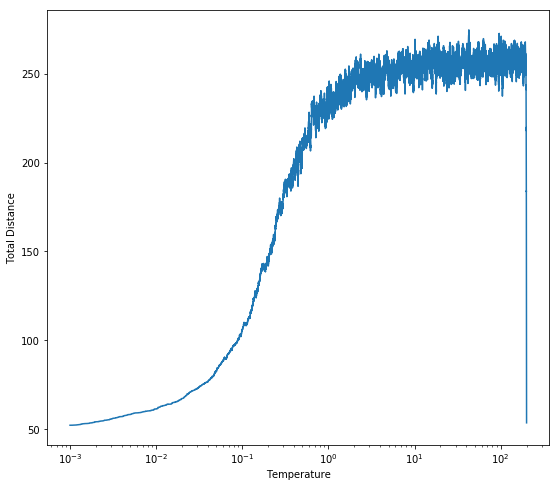

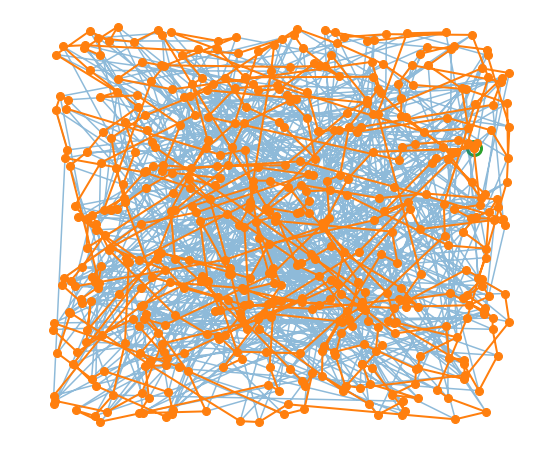

In [2]:
r_init = initialize(N = 500)
r, D, T = anneal(r_init, cycles = 5, T_max = 200, T_min = 1e-3, tau = 2e4)

fig = plt.figure(figsize = [9,8])
ax = fig.add_subplot(111)
ax.semilogx(T, D)
ax.set_xlabel('Temperature')
ax.set_ylabel('Total Distance')

fig = plt.figure(figsize = [9,8])
ax = fig.add_subplot(111)
ax.plot(r_init[:,0],r_init[:,1],'-', alpha = 0.5)
ax.plot(r[:,0],r[:,1],'-o', ms = 8, lw = 2)
ax.plot(r[0,0],r[0,1],'o', ms = 14, mfc = 'None', mew = 3, zorder = -10 )
ax.axis('off')





plt.show()